## Deep Learning & Art: Neural Style Transfer

In [14]:
#@title nst_utils

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import tensorflow as tf

class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'

def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """

    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']

    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])

    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """

    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')

    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

    return input_image


def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """

    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))

    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS

    return image


def save_image(path, image):

    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS

    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [15]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/louvre_generated.png?raw=1" style="width:750px;height:200px;">

Let's see how you can do this.

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

Run the following code to load parameters from the VGG model. This may take a few seconds.

In [16]:
import urllib
urllib.request.urlretrieve('http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat','imagenet-vgg-verydeep-19.mat')

('imagenet-vgg-verydeep-19.mat', <http.client.HTTPMessage at 0x783144e6ea50>)

In [17]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
      

The model is stored in a python dictionary where each variable name is the key and the corresponding value is a tensor containing that variable's value. To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:  
```python
model["input"].assign(image)
```
This assigns the image as an input to the model. After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:  
```python
sess.run(model["conv4_2"])
```

## 3 - Neural Style Transfer

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

In [18]:
import urllib
urllib.request.urlretrieve('https://raw.githubusercontent.com/csaybar/DLcoursera/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/louvre.jpg','louvre.jpg')

('louvre.jpg', <http.client.HTTPMessage at 0x78314335bf10>)

<ipython-input-20-03e63e0f9827>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  content_image = imageio.imread("louvre.jpg")


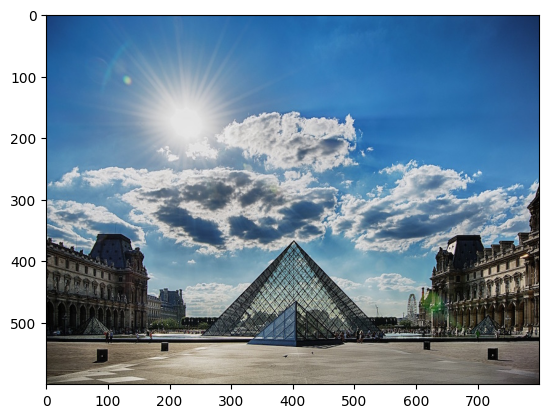

In [20]:
!pip install imageio
import imageio

content_image = imageio.imread("louvre.jpg")
imshow(content_image)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

** 3.1.1 - How do you ensure the generated image G matches the content of the image C?**

As we saw in lecture, the earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes.

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep. (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/NST_LOSS.png?raw=1" style="width:800px;height:400px;">

**Exercise:** Compute the "content cost" using TensorFlow.



In [21]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """

    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C =  a_G.get_shape().as_list()


    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled, a_C_unrolled))) * (1 / (4 * n_H * n_W * n_C))
    ### END CODE HERE ###

    return J_content

In [23]:
import tensorflow as tf

tf.compat.v1.reset_default_graph() # Use tf.compat.v1.reset_default_graph() to clear the default graph in TensorFlow 2.x.

with tf.compat.v1.Session() as test: # Use tf.compat.v1.Session() for compatibility with TensorFlow 1.x.
    tf.compat.v1.set_random_seed(1) # Use tf.compat.v1.set_random_seed() for compatibility with TensorFlow 1.x.
    a_C = tf.compat.v1.random_normal([1, 4, 4, 3], mean=1, stddev=4) # Use tf.compat.v1.random_normal() for compatibility with TensorFlow 1.x.
    a_G = tf.compat.v1.random_normal([1, 4, 4, 3], mean=1, stddev=4) # Use tf.compat.v1.random_normal() for compatibility with TensorFlow 1.x.
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 7.6410217


**Expected Output**:

<table>
    <tr>
        <td>
            **J_content**
        </td>
        <td>
           6.76559
        </td>
    </tr>

</table>

### 3.2 - Computing the style cost

For our running example, we will use the following style image:

In [25]:
import urllib
urllib.request.urlretrieve('https://raw.githubusercontent.com/csaybar/DLcoursera/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/monet_800600.jpg','monet_800600.jpg')

('monet_800600.jpg', <http.client.HTTPMessage at 0x783143f4fc10>)

<ipython-input-26-d4e7aed2f206>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  style_image = imageio.imread("monet_800600.jpg")


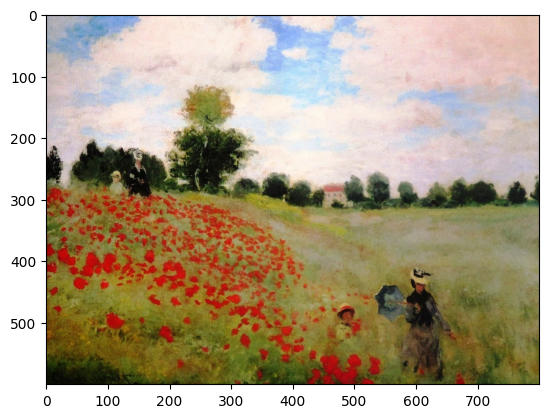

In [26]:
style_image = imageio.imread("monet_800600.jpg")
imshow(style_image)

### 3.2.1 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large.

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context.

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/NST_GM.png?raw=1" style="width:900px;height:300px;">

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture.

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image.



In [27]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A, tf.transpose(A))
    ### END CODE HERE ###

    return GA

In [29]:
import tensorflow as tf

tf.compat.v1.reset_default_graph() # Use tf.compat.v1.reset_default_graph() to clear the default graph in TensorFlow 2.x.

with tf.compat.v1.Session() as test: # Use tf.compat.v1.Session() for compatibility with TensorFlow 1.x.
    tf.compat.v1.set_random_seed(1) # Use tf.compat.v1.set_random_seed() for compatibility with TensorFlow 1.x.
    A = tf.compat.v1.random_normal([3, 2*1], mean=1, stddev=4) # Use tf.compat.v1.random_normal() for compatibility with TensorFlow 1.x.
    GA = gram_matrix(A)

    print("GA = " + str(GA.eval()))

GA = [[ 15.615461  12.248833 -29.87157 ]
 [ 12.248833  10.877857 -19.879116]
 [-29.87157  -19.879116  67.08007 ]]


### 3.2.2 - Style cost

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [30]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    ### END CODE HERE ###

    return J_style_layer

In [32]:
import tensorflow as tf

tf.compat.v1.reset_default_graph() # Use tf.compat.v1.reset_default_graph() to clear the default graph in TensorFlow 2.x.

with tf.compat.v1.Session() as test: # Use tf.compat.v1.Session() for compatibility with TensorFlow 1.x.
    tf.compat.v1.set_random_seed(1) # Use tf.compat.v1.set_random_seed() for compatibility with TensorFlow 1.x.
    a_S = tf.compat.v1.random_normal([1, 4, 4, 3], mean=1, stddev=4) # Use tf.compat.v1.random_normal() for compatibility with TensorFlow 1.x.
    a_G = tf.compat.v1.random_normal([1, 4, 4, 3], mean=1, stddev=4) # Use tf.compat.v1.random_normal() for compatibility with TensorFlow 1.x.
    J_style_layer = compute_layer_style_cost(a_S, a_G)

    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 2.2849257


### 3.2.3 Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default:

In [33]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.


We've implemented a compute_style_cost(...) function. It simply calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. Read over it to make sure you understand what it's doing.

<!--
2. Loop over (layer_name, coeff) from STYLE_LAYERS:
        a. Select the output tensor of the current layer. As an example, to call the tensor from the "conv1_1" layer you would do: out = model["conv1_1"]
        b. Get the style of the style image from the current layer by running the session on the tensor "out"
        c. Get a tensor representing the style of the generated image from the current layer. It is just "out".
        d. Now that you have both styles. Use the function you've implemented above to compute the style_cost for the current layer
        e. Add (style_cost x coeff) of the current layer to overall style cost (J_style)
3. Return J_style, which should now be the sum of the (style_cost x coeff) for each layer.
!-->


In [34]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name]
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out

        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. |

In [35]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###

    return J

In [37]:
tf.compat.v1.reset_default_graph() # Use tf.compat.v1.reset_default_graph() to clear the default graph in TensorFlow 2.x.

with tf.compat.v1.Session() as test: # Use tf.compat.v1.Session() for compatibility with TensorFlow 1.x.
    np.random.seed(3)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='purple'>

1. Create an Interactive Session
2. Load the content image
3. Load the style image
4. Randomly initialize the image to be generated
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>
Lets go through the individual steps in detail.

In [39]:
# Reset the graph
tf.compat.v1.reset_default_graph() # Use tf.compat.v1.reset_default_graph() to clear the default graph in TensorFlow 2.x.


# Start interactive session
sess = tf.compat.v1.InteractiveSession() # Use tf.compat.v1.InteractiveSession() for compatibility with TensorFlow 1.x.

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [40]:
import urllib
urllib.request.urlretrieve('https://raw.githubusercontent.com/csaybar/DLcoursera/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/louvre_small.jpg','louvre_small.jpg')

('louvre_small.jpg', <http.client.HTTPMessage at 0x783148fba510>)

In [42]:
import imageio

content_image = imageio.imread("louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

<ipython-input-42-d260898cf2c1>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  content_image = imageio.imread("louvre_small.jpg")


Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [43]:
import urllib
urllib.request.urlretrieve('https://raw.githubusercontent.com/csaybar/DLcoursera/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/monet.jpg','monet.jpg')

('monet.jpg', <http.client.HTTPMessage at 0x783148fa3790>)

In [44]:
style_image = imageio.imread("monet.jpg")
style_image = reshape_and_normalize_image(style_image)

<ipython-input-44-c7ce97c53c7d>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  style_image = imageio.imread("monet.jpg")


Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. (Feel free to look in `nst_utils.py` to see the details of `generate_noise_image(...)`; to do so, click "File-->Open..." at the upper-left corner of this Jupyter notebook.)

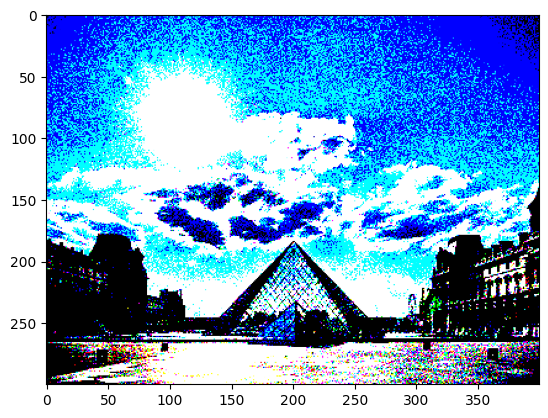

In [45]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Next, as explained in part (2), let's load the VGG16 model.

In [46]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer.
4. Compute the content cost using a_C and a_G.

In [61]:
# Reset the graph
tf.compat.v1.reset_default_graph()

# Start interactive session
sess = tf.compat.v1.InteractiveSession()

# Load the VGG model within the session's graph context
with tf.compat.v1.Session() as sess:
    model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

    # Assign the content image to be the input of the VGG model.
    sess.run(model['input'].assign(content_image))

    # Select the output tensor of layer conv4_2
    out = model['conv4_2']

    # Set a_C to be the hidden layer activation from the layer we have selected
    a_C = sess.run(out)

    # Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2']
    # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
    # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
    a_G = out

    # Compute the content cost
    J_content = compute_content_cost(a_C, a_G)
    #print("J_content = " + str(J_content.eval())) # Print the content cost

    # Assign the input of the model to be the "style" image within the session
    sess.run(model['input'].assign(style_image))

    # Now calculate J_style within the same session
    J_style = compute_style_cost(model, STYLE_LAYERS)

    # Now calculate the total cost within the same session
    J = total_cost(J_content, J_style)

    print("J = " + str(J.eval())) # Print the total cost

    # Define optimizer within the session
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=2.0) # Use tf.compat.v1.train.AdamOptimizer

    # Define train_step within the session
    train_step = optimizer.minimize(J) # Remove var_list as generated_image is within the session's graph

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


J = 247422.89


In [71]:
def model_nn(sess, input_image, num_iterations=200):
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.compat.v1.global_variables_initializer())

    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)

        # Get the generated image
        generated_image = sess.run(model['input'])

        # Print and save every 20 iterations
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            # Save the generated image
            save_image("output/" + str(i) + ".png", generated_image)

    # Save the final generated image
    save_image('output/generated_image.jpg', generated_image)

    return generated_image

In [72]:
if not os.path.exists('/content/output'):
  os.mkdir('/content/output')

You're done! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

You should see something the image presented below on the right:

<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/louvre_generated.png?raw=1" style="width:800px;height:300px;">

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. After completing and submitting this assignment, we encourage you to come back and play more with this notebook, and see if you can generate even better looking images.

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/perspolis_vangogh.png?raw=1" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/pasargad_kashi.png?raw=1" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week04/Neural%20Style%20Transfer/images/circle_abstract.png?raw=1" style="width:750px;height:300px;">